In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
train_path = "/content/drive/MyDrive/AA_MEB/v3_Binary_keratosisVSmel_dataset/train/"
val_path = "/content/drive/MyDrive/AA_MEB/v3_Binary_keratosisVSmel_dataset/val/"
test_path = "/content/drive/MyDrive/AA_MEB/v3_Binary_keratosisVSmel_dataset/test/"

train_dataset = torchvision.datasets.ImageFolder(train_path, transform = transform)
val_dataset = torchvision.datasets.ImageFolder(val_path, transform = transform)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform = transform)

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

In [6]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [7]:
get_mean_and_std(train_loader)

(tensor([0.1587, 0.1131, 0.0975]), tensor([0.2989, 0.2221, 0.1963]))

In [8]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(85),
                                transforms.Normalize((0.1584, 0.1131, 0.0976),
                                                     (0.2992, 0.2226, 0.1969))])

In [9]:
train_path = "/content/drive/MyDrive/AA_MEB/v3_Binary_keratosisVSmel_dataset/train/"
val_path = "/content/drive/MyDrive/AA_MEB/v3_Binary_keratosisVSmel_dataset/val/"
test_path = "/content/drive/MyDrive/AA_MEB/v3_Binary_keratosisVSmel_dataset/test/"

train_dataset = torchvision.datasets.ImageFolder(train_path, transform = transform)
val_dataset = torchvision.datasets.ImageFolder(val_path, transform = transform)
test_dataset = torchvision.datasets.ImageFolder(test_path, transform = transform)


In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

In [11]:
print("training set contains:", len(train_dataset), "images")
print("validation set contains:", len(val_dataset), "images")
print("testing set contains:", len(test_dataset), "images")

training set contains: 502 images
validation set contains: 62 images
testing set contains: 64 images


In [12]:
print(train_dataset.class_to_idx)

{'keratosis': 0, 'melanoma': 1}


In [13]:
images, labels = next(iter(train_loader))

images.shape # [batch_size, color_channels, height, width]

torch.Size([16, 3, 200, 200])

In [14]:
print("Number of images in training set: {}".format(len(train_dataset)))
print("Number of images in test set: {}".format(len(val_dataset)))
print("Number of images in test set: {}".format(len(test_dataset)))

print("...")

print("Number of batches in the train loader: {}".format(len(train_loader)))
print("Number of batches in the test loader: {}".format(len(val_loader)))
print("Number of batches in the test loader: {}".format(len(test_loader)))

Number of images in training set: 502
Number of images in test set: 62
Number of images in test set: 64
...
Number of batches in the train loader: 32
Number of batches in the test loader: 4
Number of batches in the test loader: 4


In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
            
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1), # 382x382x16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2), #191x192x16

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, stride=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        
        self.fc_model = nn.Sequential(
            nn.Linear(25392,10024),
            nn.BatchNorm1d(10024),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(10024,1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(1024,2))

    def forward(self, x):
        #print(x.shape)
        out = self.cnn_model(x)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        #nn.Flatten(),
        #print(out.shape)
        out = self.fc_model(out)
        #print(out)
        return out

In [16]:
CUDA = torch.cuda.is_available()

if CUDA:
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [17]:
criterion=nn.CrossEntropyLoss()

model = CNN().to(device)
optimizer=torch.optim.SGD(model.parameters(), lr=1e-4)

In [18]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

In [19]:
import numpy as np

epochs = 45
min_valid_loss = np.inf

train_loss_values = []
valid_loss_values = []
train_acc = []
val_acc = []

for e in range(epochs):
    train_loss = []
    running_train_accuracy = 0.00

    model.train()     # Optional when not using Model Specific layer
    size = len(train_loader.dataset)
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
            batch, c, h, w = data.shape 
        
        optimizer.zero_grad()
        predictions = model(data)
        t_loss = criterion(predictions,labels)
        t_loss.backward()
        optimizer.step()
        train_loss.append(t_loss.item())

        running_train_accuracy += accuracy(predictions, labels)

    running_train_accuracy /= len(train_loader)
    train_acc.append(running_train_accuracy.cpu())

    train_loss_values.append(np.array(train_loss).mean())

    valid_loss = []
    
    model.eval()     # Optional when not using Model Specific layer
    running_val_accuracy = 0.00
    for data, labels in val_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        predictions = model(data)
        v_loss = criterion(predictions,labels)
        valid_loss.append(v_loss.item())
        running_val_accuracy += accuracy(predictions, labels)

    running_val_accuracy /= len(val_loader)

    valid_loss_values.append(np.array(valid_loss).mean())
    val_acc.append(running_val_accuracy.cpu())

    print(f'Epoch {e+1} \t\t Training Loss: {t_loss.item()} \t\t Validation Loss: {v_loss.item()}')
    print(f'Metrics \t\t Training accuracy: {running_train_accuracy} \t\t Validation accuracy: {running_val_accuracy}') 
        
        
    # Saving State Dict
    torch.save(model.state_dict(), '/content/drive/MyDrive/AA_MEB/01_v3_model.pth')

Epoch 1 		 Training Loss: 0.7413504719734192 		 Validation Loss: 0.6854434013366699
Metrics 		 Training accuracy: 0.5423176884651184 		 Validation accuracy: 0.5647321343421936
Epoch 2 		 Training Loss: 0.8420939445495605 		 Validation Loss: 0.6167535781860352
Metrics 		 Training accuracy: 0.6360676884651184 		 Validation accuracy: 0.6450892686843872
Epoch 3 		 Training Loss: 0.537706196308136 		 Validation Loss: 0.5941839218139648
Metrics 		 Training accuracy: 0.6595051884651184 		 Validation accuracy: 0.6473214626312256
Epoch 4 		 Training Loss: 0.6614452600479126 		 Validation Loss: 0.6758849024772644
Metrics 		 Training accuracy: 0.67578125 		 Validation accuracy: 0.671875
Epoch 5 		 Training Loss: 0.382561057806015 		 Validation Loss: 0.704133152961731
Metrics 		 Training accuracy: 0.6920573115348816 		 Validation accuracy: 0.6584821343421936
Epoch 6 		 Training Loss: 0.6092403531074524 		 Validation Loss: 0.43879321217536926
Metrics 		 Training accuracy: 0.6907551884651184 		 Vali

Text(0, 0.5, 'loss')

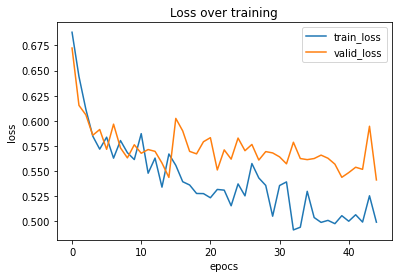

In [20]:
plt.title("Loss over training")
plt.plot(train_loss_values)
plt.plot(valid_loss_values)
plt.legend(["train_loss", "valid_loss"])
plt.xlabel("epocs")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

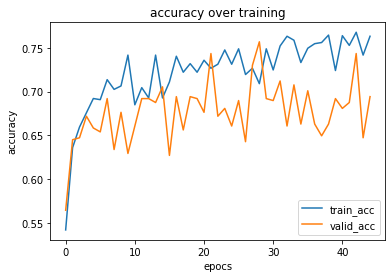

In [21]:
plt.title("accuracy over training")
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["train_acc", "valid_acc"])
plt.xlabel("epocs")
plt.ylabel("accuracy")

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score, accuracy_score, classification_report

In [23]:
y_pred = []
y_pred_prob = []
y_true = []

model = CNN().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/AA_MEB/01_v3_model.pth'))
model.eval()

# iterate over test data
for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs) # Feed Network

        output_pred = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output_pred)
        output_prob = torch.softmax(output.cpu(), dim=1)[:, 1].data.cpu().numpy()
        y_pred_prob.extend(output_prob) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        #labels = labels.cpu()
        y_true.extend(labels) # Save Truth

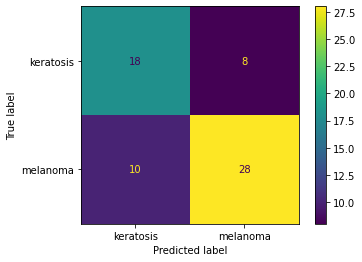

In [24]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.class_to_idx)
disp.plot()

In [25]:
cr = classification_report(y_true, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.64      0.69      0.67        26
           1       0.78      0.74      0.76        38

    accuracy                           0.72        64
   macro avg       0.71      0.71      0.71        64
weighted avg       0.72      0.72      0.72        64

